In [1]:
# Common
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from IPython.display import clear_output as cls

# Data 
from tqdm import tqdm 
from glob import glob
import tensorflow.data as tfd

# Data Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# Model
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras import applications as tka

In [2]:
!pip install keras_tuner
import keras_tuner as kt
cls()

In [3]:
# The batch size
BATCH_SIZE = 64

# Image dims 
IMAGE_SIZE = (120,120)                                    # Even this will work

# Buffer size
BUFFER = 1000

# Autotuning
AUTOTUNE = tfd.AUTOTUNE

In [4]:
# Setting the Random Seeds
np.random.seed(1024)
tf.random.set_seed(1024)


In [5]:
train_path = "./data2/training_data/"
test_path  = "./data2/testing_data/"

In [6]:
# Get the class Names
class_names = sorted(os.listdir(train_path))

# Total number of classes
n_classes = len(class_names)

# Show
print(f"Total Number of Classes : {n_classes}")
print(f"Class Names : \n{class_names}")

Total Number of Classes : 36
Class Names : 
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [7]:
print(f"Training Images : {sum([len(os.listdir(train_path + name)) for name in class_names])}")
print(f"Testing  Images : {sum([len(os.listdir(test_path + name)) for name in class_names])}")

Training Images : 20628
Testing  Images : 3242


In [8]:
def load_image(image_path:str):

    '''
    This is a pwerful function designed to facilitate the loading of images from a specified image path, while simultaneously 
    carrying out critical preprocessing steps. Specifically, this function implements two key preprocessing techniques : resizing and normalization.
    
    By leveraging resizing, this function standardizes the dimensions of the images, ensuring that they are of a consistent size and format.
    This preprocessing step is essential to ensure that our analysis can be carried out accurately and efficiently, as it eliminates the risk
    of errors or inconsistencies that can arise from variations in image dimensions.
    
    In addition to resizing, this function also incorporates normalization as a critical preprocessing step. By standardizing the images,
    this technique helps to eliminate any variations that can affect the accuracy of our analysis, ensuring that our conclusions are robust and reliable.

    Argument : 
        image_path : The path to the image file.
    
    Return : 
        image : The loaded and prerocessed image.
    '''
    
    # Load image file
    image_loaded = tf.io.read_file(image_path)

    try:
        # Decode the png image
        image_decoded = tf.image.decode_png(contents=image_loaded, channels=3)
        
        # Convert the dtype
        image_cnvt = tf.image.convert_image_dtype(image=image_decoded, dtype=tf.float32)

        # Resize the image
        image_resize = tf.image.resize(images=image_cnvt, size=IMAGE_SIZE)

        # Normalize image
        image_norm = tf.clip_by_value(image_resize, clip_value_min=0.0, clip_value_max=1.0)

        # Just for security
        image = tf.cast(x=image_norm, dtype=tf.float32)

        # return
        return image
    except:
        pass

In [9]:
def load_data(root_path, class_names, trim=None, shuffle=False, split=None):

    '''
    This function is designed to simplify the process of collecting file paths from the root path based on class names, while simultaneously 
    loading the associated images and labels. By leveraging this function, we can streamline our data collection process, ensuring that we can
    rapidly access the files we need for our analysis.
    
    This functionality is particularly useful when working with large datasets, as it enables us to avoid the tedious manual effort of collecting
    file paths and loading images and labels separately. Once the images and labels have been collected, this function takes the additional step of
    converting them into a TensorFlow dataset, further streamlining the analysis process. 
    
    By transforming the data into this format, we can leverage TensorFlow's powerful functionality and algorithms, enabling us to quickly and 
    accurately analyze the data and extract valuable insights.

    Overall, this function is a powerful tool that streamlines the data collection and preprocessing process, enabling us to extract valuable
    insights from large and complex datasets.
    
    Arguments : 
        root_path   : The main directory from which the data should be collected.
        class_names : These are the class names or the sub directory names where the image files are present.
    
    Return : 
        data_set : The Tensorflow dataset of the images and labels.
    '''

    # Collect all file paths
    if trim is not None:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")[:trim]]
        
    else:
        details = [(path, name) for name in class_names for path in glob(pathname=f"{root_path}/{name}/*.png")]


    # Create space for images and labels
    images = np.empty(shape=(len(details), *IMAGE_SIZE, 3), dtype='float32')
    labels = np.empty(shape=(len(details), 1), dtype='int64')


    # Iterate over all file paths
    for index, (path, name) in tqdm(enumerate(details), desc="Loading"):

        # Load the image
        image = load_image(image_path=path)

        # get the label
        label = class_names.index(name)

        # Store this image and label
        images[index] = image
        labels[index] = label
    
    # Convert the data into tensorflow data
    data_set = tfd.Dataset.from_tensor_slices((
        images, labels
    ))

    # Shuffle if needed
    if shuffle:
        data_set = data_set.shuffle(BUFFER)
    
    # Split the data if needed
    if split is not None:
        
        # get the data sizes
        test_size = int(split * len(images))
        train_size = int(len(images) - test_size)
        
        # Split the data
        train_set = data_set.take(train_size)
        test_set  = data_set.skip(train_size).take(test_size)
        
        # Batchify the data
        train_set = train_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        test_set = test_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return data
        return train_set, test_set
    
    else:
        # The whole data
        data_set = data_set.batch(BATCH_SIZE).prefetch(AUTOTUNE)
        
        # Return complete data
        return data_set


In [10]:
# Load Training data
train_ds = load_data(root_path=train_path, class_names=class_names, trim=300, shuffle=True)

# Load Validation data
test_ds, valid_ds = load_data(root_path=test_path, class_names=class_names, shuffle=True, split=0.2)
cls()

In [11]:
print(f"Training Data Size   : {tf.data.experimental.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.experimental.cardinality(valid_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.experimental.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 10816
Validation Data Size : 704
Testing Data Size    : 2624


In [12]:
def show_images(data, GRID=[8,8], FIGSIZE=(20,20), model=None):
    
    '''
    This function is all about loading up our dataset and visualizing it with the help of matplotlib. By leveraging the power of
    this powerful visualization tool, we can quickly and easily analyze our images and extract valuable insights in the process. 
    The key feature of this function is its ability to display each image in our dataset in detail, giving us a clear and concise
    view of all the key details. 
    
    Arguments : 
        data    : This refers to the dataset from which the images and labels should be extracted.
        GRID    : This represents the total number of images broken up into rows and columns.
        FIGSIZE : This is a matplotlib property for setting the figure size.
        model   : In case if model is provided, then the function will make predictions and show the predictions as well.
    
    Returns : 
        None : It does not returns anything but it plots the images. 
    '''
    
    # Plotting configurations
    plt.figure(figsize=FIGSIZE)
    n_images = GRID[0] * GRID[-1]
    
    # Get the data for data visualization
    images, labels = next(iter(data))
    
    # Iterate over data 
    for n_image, (image, label) in enumerate(zip(images, labels)):
        
        # Plot the image into the subplot.
        plt.subplot(GRID[0], GRID[1], n_image+1)
        plt.imshow(tf.squeeze(image))
        plt.axis('off')
        
        # Adding the title
        if model is not None:
            image = tf.expand_dims(image, axis=0)
            pred = model.predict(image)[0]
            max_index = tf.argmax(pred)
            score = pred[max_index]
            pred_label = class_names[max_index]
            title = "Pred : {}\nScore : {:.4}".format(pred_label, score)
            plt.title(title)
        
        # Break the loop 
        if n_image+1>=n_images:
            break
    
    # Show the final plot
    plt.tight_layout()
    plt.show()

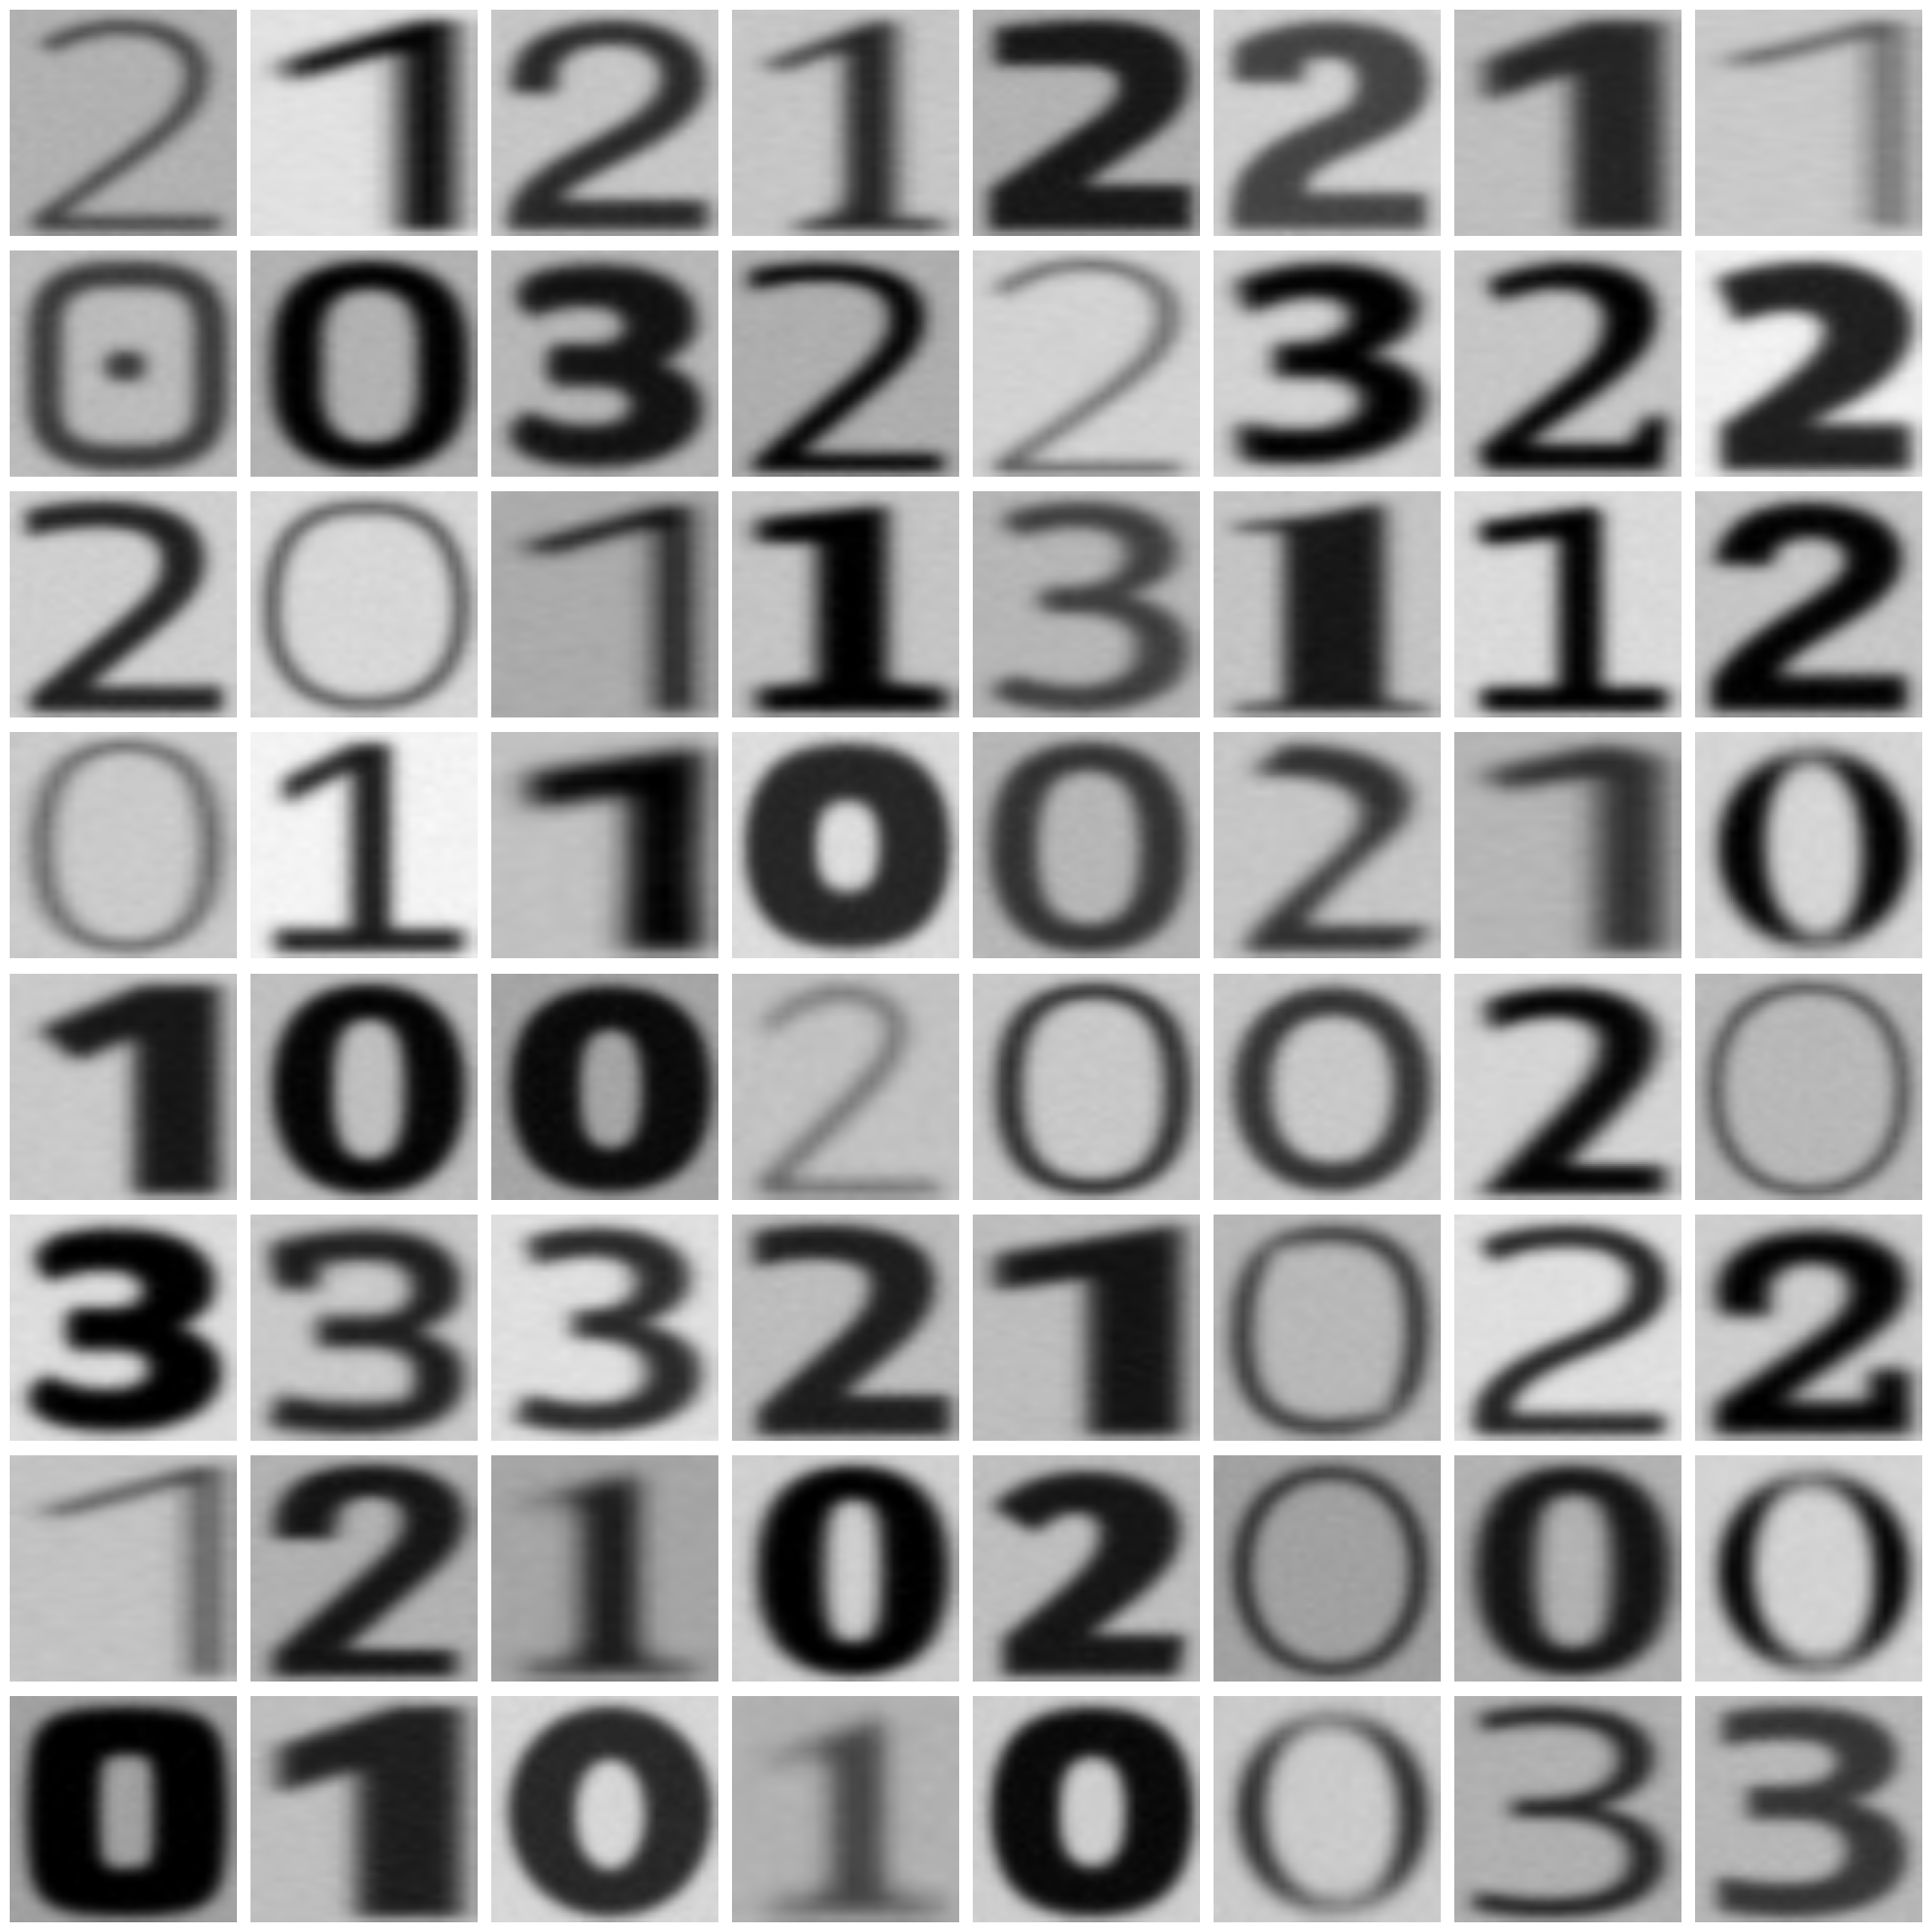

In [13]:
show_images(data=train_ds)

In [14]:
# All the backbones will be accessed through a name.
BACKBONE_NAMES = [
    'ResNet50',
    'ResNet50V2',
    'ResNet152V2',
    'Inception',
    'Xception',
    'MobileNet'
]

In [15]:
# Load the backbones
BACKBONES = [
    tka.ResNet50(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.ResNet152V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.InceptionV3(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.Xception(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
    tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),
]

for backbone in BACKBONES:
    backbone.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 105s 1us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 106s 1us/step
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 263s 1us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 96s 1us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 94s 1us/step


C:\Users\hanym\AppData\Local\Temp\ipykernel_10976\2307984655.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  tka.MobileNet(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3)),


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 20s 1us/step


https://storage.googleapis.com/tensorflow/keras-applications/resnet/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5

In [16]:
# store the Backbone histories.
BACKBONE_HISTORIES = []

# Iterate over the backbones
for name, backbone in zip(BACKBONE_NAMES, BACKBONES):
    
    # Show
    print(f'BACKBONE : {name.title()}\n')
    
    # Create a simple model architecture.
    dummy_model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone, 
        layers.GlobalAveragePooling2D(name="GAP"),
        layers.Dropout(0.2, name="DropoutLayer"),
        layers.Dense(len(class_names), activation='softmax', name="OutputLayer")
    ], name=name.strip().title())
    
    # Show the summary
    print('-'*100)
    print("Model Summary\n")
    dummy_model.summary()
    print("\n")
    print('-'*100)
    
    # Compile the model.
    dummy_model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    # Train the model
    print("\n")
    print('-'*100)
    print("Model Training\n")
    history = dummy_model.fit(train_ds, validation_data=test_ds, epochs=10)
    print("\n")
    print('-'*100)
    
    # Store the history
    BACKBONE_HISTORIES.append(
        pd.DataFrame(history.history)
    )
    
    # clear the output.
    cls()

In [17]:
# Using the best validation accuracy as baseline accuracy.
BASELINE_ACC = max(BACKBONE_HISTORIES[BACKBONE_NAMES.index('ResNet50V2')]['val_accuracy'])

# Similarly, using the best validation loss as the baseline loss.
BASELINE_LOSS = min(BACKBONE_HISTORIES[BACKBONE_NAMES.index('ResNet50V2')]['val_loss'])

print('--'*50)
print(" "*25 + f"Best Loss : {np.round(BASELINE_LOSS, decimals=4)}; Best Accuracy : {np.round(BASELINE_ACC, decimals=3)*100}%")
print('--'*50)

----------------------------------------------------------------------------------------------------
                         Best Loss : 0.9105; Best Accuracy : 87.9%
----------------------------------------------------------------------------------------------------


In [18]:
def build_model(hp):
    
    # Backbone
    backbone = tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
    backbone.trainable = False
    
    # Base Model
    model = keras.Sequential(layers=[
        layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
        backbone,                                                            # ResNet50V2
        layers.GlobalAveragePooling2D(name="GAP"),
    ], name=name.strip().title())
    
    # Params to tweak
    for i in range(hp.Choice('n_layers', [1,2,4])):
        model.add(layers.Dense(hp.Choice('n_units', [64, 256])))
    model.add(layers.Dropout(hp.Choice('rate', [0.2,0.4])))
    
    # Output layer
    model.add(layers.Dense(len(class_names), activation='softmax'))
    
    # Compile the model.
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(),
        metrics=['accuracy']
    )
    
    return model

In [19]:
# Initialize tuner
tuner = kt.RandomSearch(hypermodel=build_model, objective='val_loss', project_name='ResNet50V2-OCR-3')

# Start hyperparameter search.
tuner.search(
    train_ds, 
    validation_data=valid_ds,
    epochs = 5
)

Trial 10 Complete [00h 05m 46s]
val_loss: 0.4362936019897461

Best val_loss So Far: 0.24254989624023438
Total elapsed time: 00h 58m 41s


In [25]:
# Get the best model and build it
best_model = tuner.get_best_models()[0]
best_model.build(input_shape=(*IMAGE_SIZE, 3))

ValueError: Sequential model 'Mobilenet' has already been configured to use input shape (None, 120, 120, 3). You cannot build it with input_shape (120, 120, 3)

In [ ]:
# Best Model Summary
best_model.summary()

In [26]:
# Training the model
best_model_history = best_model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=100,
    callbacks = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('StandardOCR-ResNet50V2.keras', save_best_only=True)

    ]
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 75s 421ms/step - accuracy: 0.9458 - loss: 0.2921 - val_accuracy: 0.9167 - val_loss: 1.1941
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 69s 407ms/step - accuracy: 0.8962 - loss: 0.9805 - val_accuracy: 0.9321 - val_loss: 0.5586
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 68s 400ms/step - accuracy: 0.9152 - loss: 0.6727 - val_accuracy: 0.8858 - val_loss: 1.7657
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 67s 396ms/step - accuracy: 0.8970 - loss: 1.0967 - val_accuracy: 0.9336 - val_loss: 0.8472
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 66s 391ms/step - accuracy: 0.9113 - loss: 1.0057 - val_accuracy: 0.9244 - val_loss: 1.1714


In [27]:
# Valid Data
best_model.evaluate(valid_ds)


11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 341ms/step - accuracy: 0.9327 - loss: 0.5298


[0.6130189299583435, 0.9259259104728699]

In [28]:
# Test data
best_model.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 363ms/step - accuracy: 0.6976 - loss: 2.9495


[2.0233266353607178, 0.7918273210525513]

In [30]:
# Backbone
backbone = tka.ResNet50V2(include_top=False, weights='imagenet', input_shape=(*IMAGE_SIZE, 3))
backbone.trainable = True

# Base Model
model = keras.Sequential(layers=[
    layers.InputLayer(input_shape=(*IMAGE_SIZE, 3), name="InputLayer"),
    backbone,                                                            # ResNet50V2
    layers.GlobalAveragePooling2D(name="GAP"),
    layers.Dense(64),
    layers.Dense(64),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

# Compile the model.
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    metrics=['accuracy']
)

# History 
history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=100,
    callbacks = [
        callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        callbacks.ModelCheckpoint('StandardOCR-ResNet50V2-2.keras', save_best_only=True)
    ]
)

Epoch 1/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.1128 - loss: 3.6024 - val_accuracy: 0.1343 - val_loss: 3.2675
Epoch 2/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 290s 2s/step - accuracy: 0.4024 - loss: 2.2981 - val_accuracy: 0.5478 - val_loss: 1.9532
Epoch 3/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 277s 2s/step - accuracy: 0.6664 - loss: 1.4446 - val_accuracy: 0.7593 - val_loss: 1.2329
Epoch 4/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 276s 2s/step - accuracy: 0.8172 - loss: 0.8996 - val_accuracy: 0.8843 - val_loss: 0.8190
Epoch 5/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - accuracy: 0.9053 - loss: 0.5502 - val_accuracy: 0.9522 - val_loss: 0.3716
Epoch 6/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step - accuracy: 0.9462 - loss: 0.3662 - val_accuracy: 0.9738 - val_loss: 0.1624
Epoch 7/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 284s 2s/step - accuracy: 0.9663 - loss: 0.2566 - val_accuracy: 0.9660 - val_loss: 0.4120
Epoch 8/100
169/169 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9776 - loss: 0.1885 - 

In [31]:
# Evaluation on Test Set
model.evaluate(test_ds)

41/41 ━━━━━━━━━━━━━━━━━━━━ 20s 481ms/step - accuracy: 0.8819 - loss: 0.8470


[0.5066559910774231, 0.929067075252533]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━

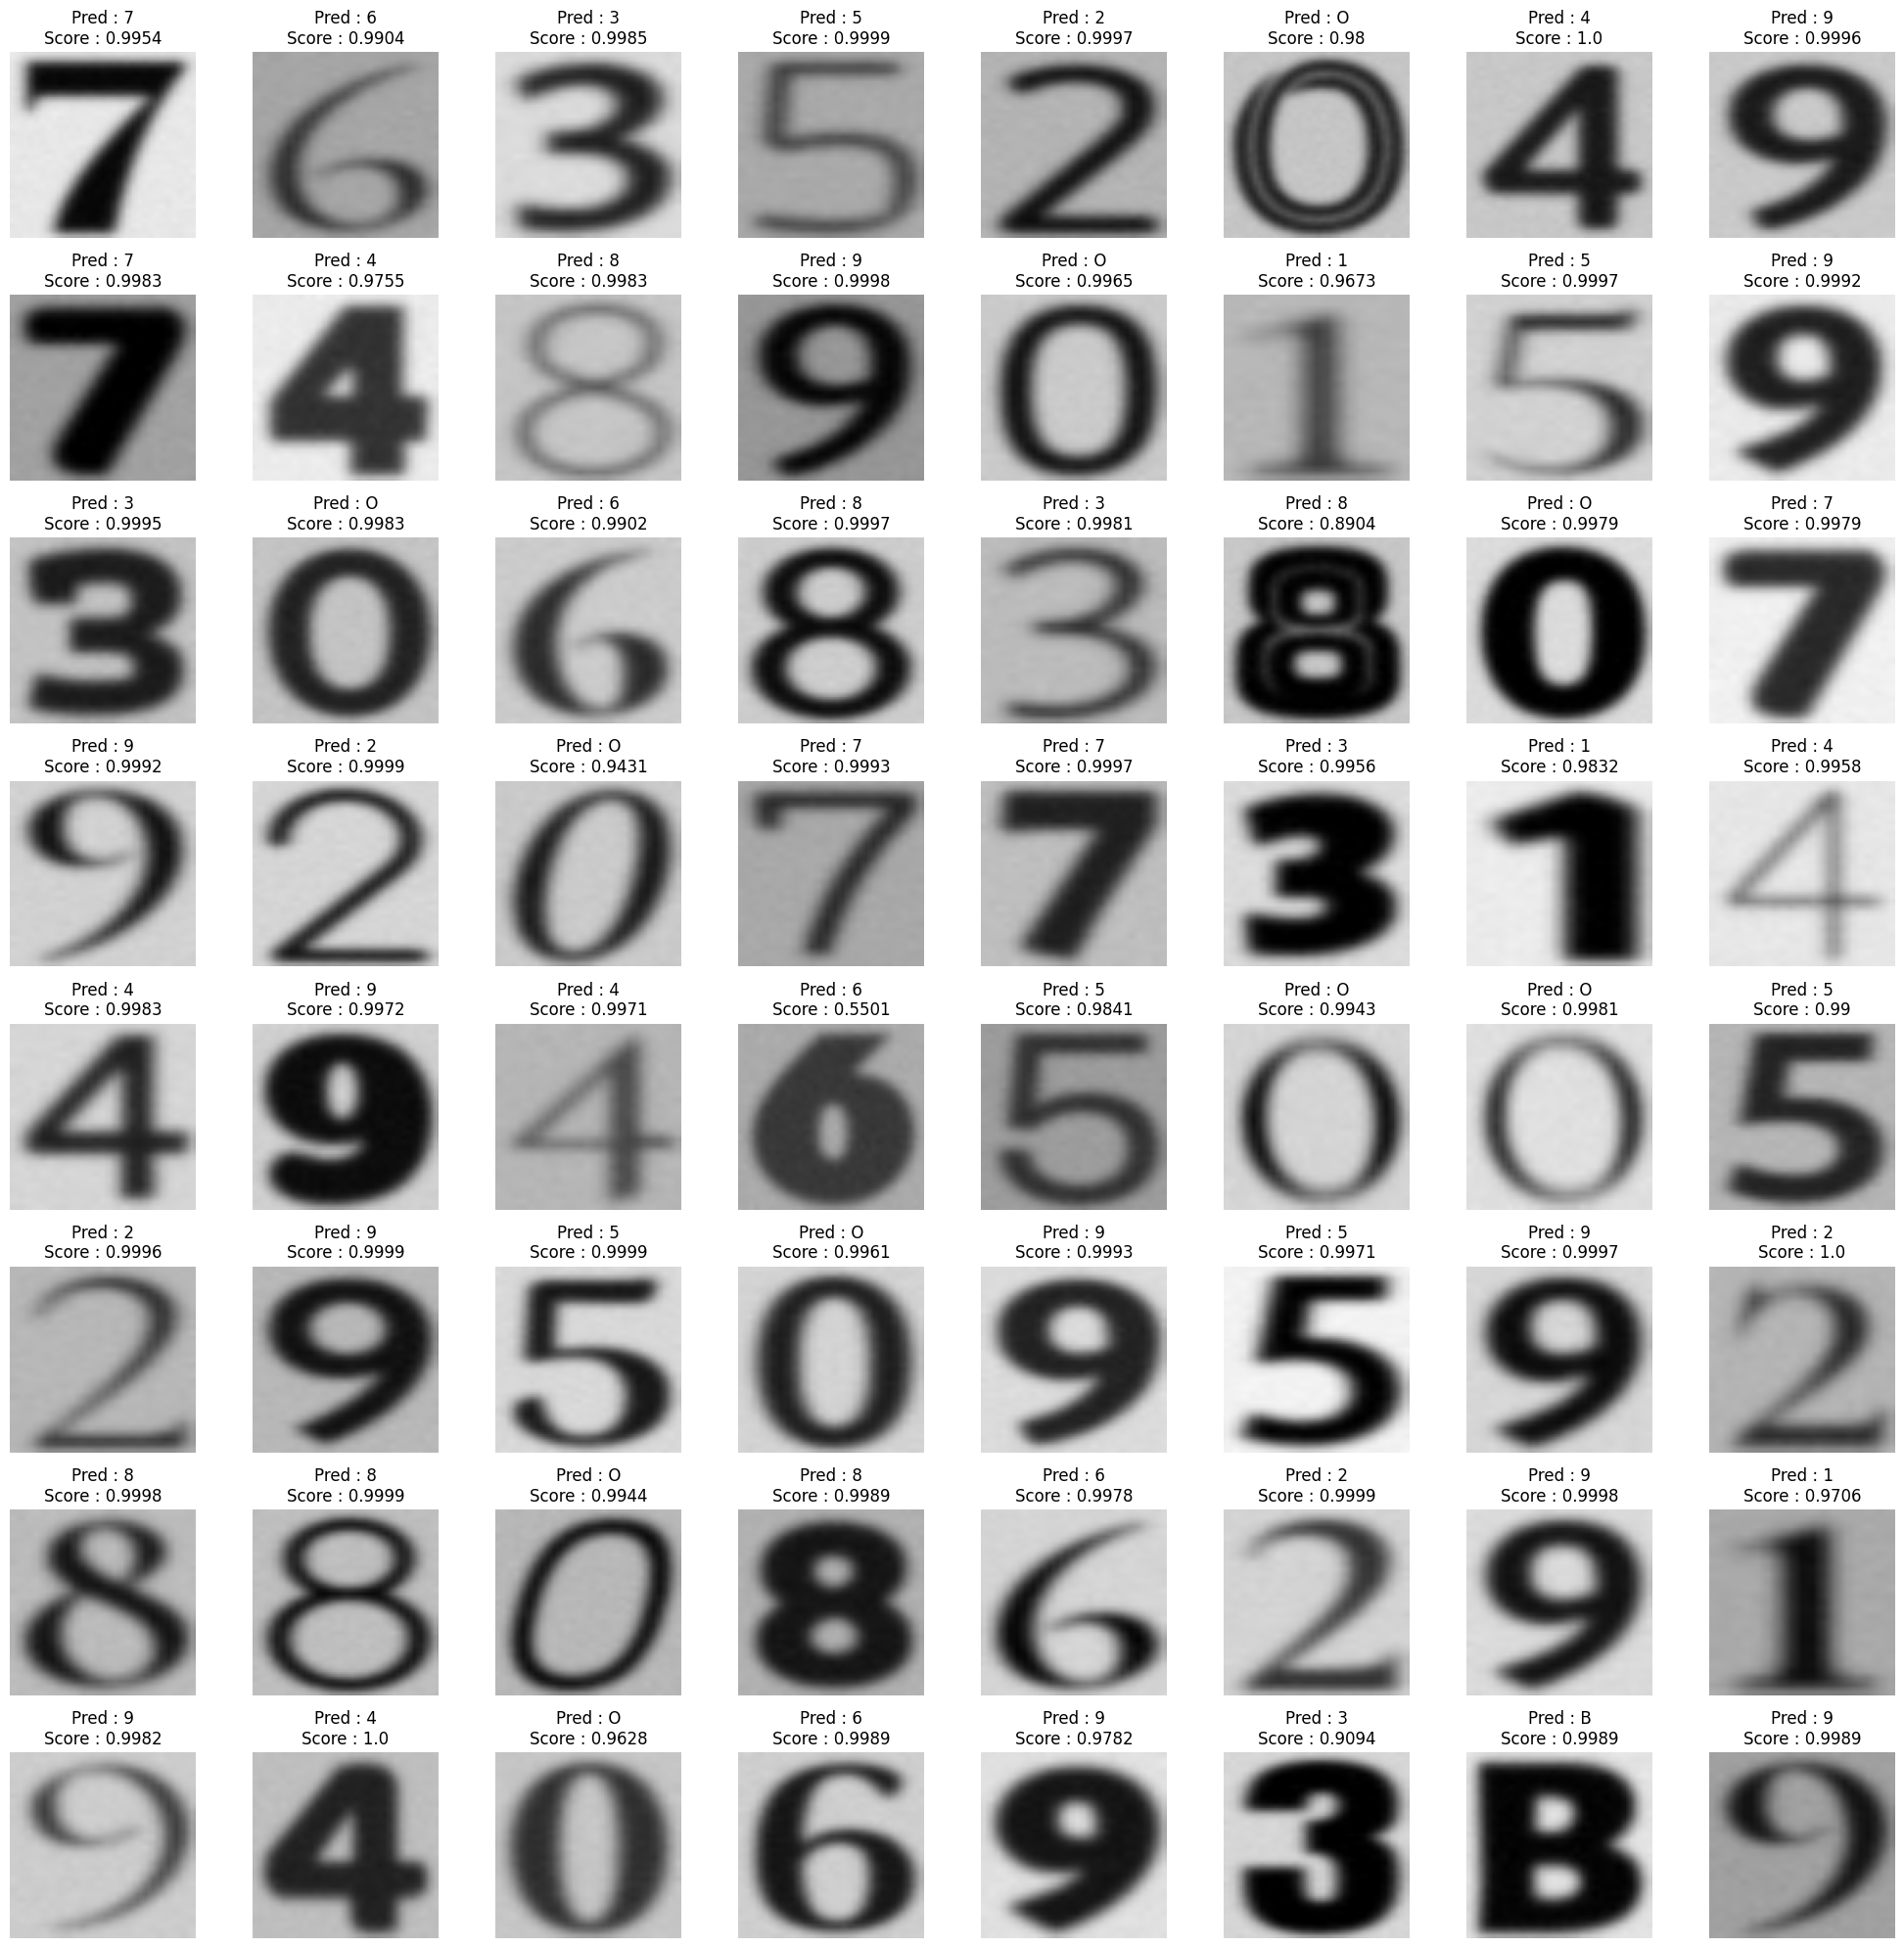

In [32]:
show_images(data=test_ds, model=model)

In [ ]:
model.save('ocr.h5')

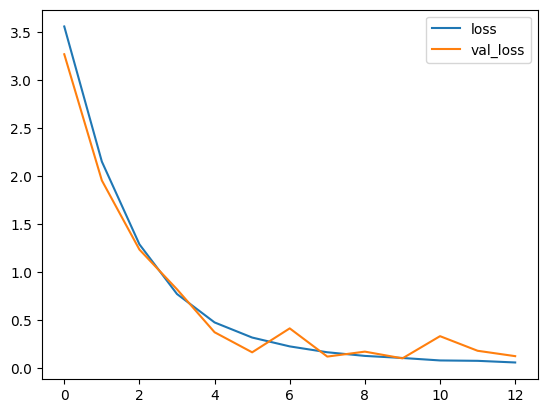

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['loss', 'val_loss'])